TODO:
Learn to use visualization techniques to study:
1. missing data
2. distributions
3. correlation heatmaps
4. pairplots,
5. t-SNE

pre-proc:
1. use catboost for categoric data

model: 


In [1]:
%run ../../EfratPack.ipynb

# JET House Prices Prediction 

# instruction
## Part 1:
[Model submission is done through Kaggle]
Part 1 - EDA
1. Which 3 features have the highest number of missing values
2. How the price behave over the years?
3. Plot the the feature distribution using histograms
4. Compute and order the features by their correlation with label
5. Add more EDA that will help you understand the data and support your modeling decisions

Part 2 - baseline
1. Train the simplest baseline model possible
2. submit your baseline results and share the results

## Part 2:
[Model submission is done through Kaggle]
Your solution:  go wild and build the best performing model!Which model you choose and why (relate to relevant EDA)?
Choose a validation creation process, why you choose it? what is the baseline performance?
Which smart tricks you used to boost your model performance?
Describe potential generalization issues (e.g. overfit/underfit)? How can you handle these?
submit your model and improve your rank in the leaderboard!

Deliverables
A final submission and score of you team in the leaderboard
Working and easy to follow notebook with the 3 parts completed and that produce your best submission.
Slides explaining your project: 
1. EDA
2. decision made
3. feature analysis
4. validation
5. modeling
6. etc



# Imports and loadings

In [2]:
#import tensorflow as tf
#import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

# general functions

In [3]:
def printt(df,Name=None,verbose=True):    
    if verbose==True:
        print('----------------------')
        if Name!=None:
            print(Name)
        print(df)

In [4]:
def plot_perd(y, y_pred,verbose=True):
    if verbose==True:
        plt.figure(figsize=(5, 5))
        plt.scatter(y, y_pred, color='blue')
        plt.title('True vs Predicted Values')
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.plot([min(y), max(y)], [min(y), max(y)], color='red') # Line for perfect predictions
        plt.grid(True)
        plt.show()


# Define Config params


In [5]:
Config_params = dict()
Config_params['nan_counts_threshold'] = .15
Config_params['filter_out_HighNA'] = 1
Config_params["model"]='CatBoost' #'decisionTree','CatBoost'
Config_params["drop_categoric"]=True #

# Load the dataset

In [6]:
test_file_path = "project/test.csv"
train_file_path = "project/train.csv"
testset_df = pd.read_csv(test_file_path)
dataset_df = pd.read_csv(train_file_path)
print("Full test set shape is {}".format(testset_df.shape))
print("Full train dataset shape is {}".format(dataset_df.shape))
id_file = testset_df['Id']
# Assuming 'dataset_df' is your DataFrame
y = dataset_df['SalePrice']
X = dataset_df.drop('SalePrice', axis=1)
# Splitting the dataset into training and testing sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

Full test set shape is (1459, 80)
Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

# Pre proccessing functions

## drop ID

In [7]:
# Custom transformer to remove NAs
class drop_ID(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):        
        self.verbose = verbose
    def fit(self, X, y=None):
        printt('','In drop_ID fit',verbose=self.verbose)
        return self

    def transform(self, X, y=None):
        printt(X.shape,'drop_ID in X.shape',verbose=self.verbose)
        # Ensure 'Id' column is removed safely
        if 'Id' in X.columns:
            return X.drop('Id', axis=1)
        else:
            return X

## NAs

In [8]:
def imput_mean_mode(X,mean_mode):
    # impute missing value by pre calc mean or mode :
    col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    # save the mean and the mode for later imputation
    combined_stats = pd.Series(dtype=object)
    for col in X.columns:        
        X[col].fillna(mean_mode[col], inplace=True)
    return X

In [9]:
def calc_mean_mode(X):
    # find the mean of numrical columns and the mode of object columns
    # return :
    # combined_stats = mean amd mode in the same shape as orign,
    # col_numeric,col_object =list of numeric and obkect coumln names
    col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    printt(col_numeric,'col_numeric',False)
    printt(col_object,'col_object',False)
    # save the mean and the mode for later imputation
    means = X[col_numeric].mean()
    modes = X[col_object].mode().iloc[0]
    # Step 3: Combine results, maintaining the original arrangement
    combined_stats = pd.Series(dtype=object)
    for col in X.columns:
        if col in means:
            combined_stats[col] = means[col]
        elif col in modes:
            combined_stats[col] = modes[col]
    return combined_stats,col_numeric,col_object

In [10]:
def find_bad_col(X,threshold=None,verbose=False):
    # drop col with na in amount more than threshold
    if threshold is not None:
        thresh = len(X)*threshold//1        
        na_counts    = X.isna().sum()
        columns_to_keep_ = na_counts[na_counts < thresh].index
        columns_to_remove_ = na_counts[na_counts >= thresh].index
    else:
        columns_to_keep_ = X.columns
        columns_to_remove_ = pd.Index([])        

    if verbose==True:
        nan_counts  = X.isna().sum().sort_values(ascending=False).head(20)/len(X)*100
        print(f"features with the highest number of missing values in %")
        print(f"{nan_counts}%")
        printt(len(columns_to_keep_),'len(columns_to_keep_)',verbose=verbose)
        printt(len(columns_to_remove_),'len(columns_to_remove_)',verbose=verbose)
        if len(columns_to_remove_)>0:
            printt(columns_to_remove_,'columns_to_remove_',verbose=verbose)           

    return columns_to_keep_,columns_to_remove_


In [11]:
def print_row_nan_counts(X,verbose=False):
    # print number of Rows with missing values
    row_nan_counts = X.isna().sum(axis=1) 
    top_row_nan_counts = row_nan_counts.sort_values(ascending=False)
    if verbose==True:
        print("number of Rows with missing values:")
        print(top_row_nan_counts.value_counts())


In [12]:
def print_missingVal_groups(X,verbose=False):
    row_nan_counts = X.isna().sum(axis=1) 
    rows_with_missing_values = X[row_nan_counts >0]
    unique_missing_column_groups = set()
    # Iterate through rows and identify unique groups of missing columns
    for _, row in rows_with_missing_values.iterrows():
        # Extract groups of 5 columns
        groups = tuple(row.index[row.isna()])
        # Add the unique group to the set
        unique_missing_column_groups.add(groups)
    
    # Sort the unique groups by their length
    sorted_unique_missing_column_groups = sorted(unique_missing_column_groups, key=lambda x: len(x))
    # Print the unique groups of 5 missing columns
    if verbose==True:
        print('\nmissing values groups:')
        for i, group in enumerate(sorted_unique_missing_column_groups, start=1):
            print(f"Group {i} of {len(group)} missing columns: {group}")

In [13]:
class remove_NAs_col(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=None,verbose=False):        
        self.threshold = threshold  # Minimum non-NA values required to keep a column
        self.verbose = verbose
    def fit(self, X, y=None):
        printt('','In RemoveNAs Col fit',verbose=self.verbose)
        # If threshold is set, identify columns to keep based on the threshold
        self.columns_to_keep_,self.columns_to_remove_ = find_bad_col(X,self.threshold,self.verbose)
        return self
    
    def transform(self, X, y=None):
        printt('','In RemoveNAs Col transform',verbose=self.verbose)
        # Drop columns not meeting the threshold requirement
        printt(X.shape,'X.shape',verbose=self.verbose)
        X_transformed = X.loc[:, self.columns_to_keep_]
        printt(X_transformed.shape,'X_transformed.shape',verbose=self.verbose)        
        return X_transformed

In [14]:
class imput_NAs_row(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):        
        self.column_means_ = None
        self.verbose = verbose
        self.col_numeric = None
        self.col_object = None
    def fit(self, X, y=None):
        printt('','In imput_NAs_row fit',verbose=self.verbose)
        # Calculate mean values for each column, ignoring NA's
        printt(X.shape,'imput_NAs_row in X.shape',verbose=self.verbose)
        # save the mean and the mode for later imputation
        self.mean_mode,self.col_numeric,self.col_object = calc_mean_mode(X)
        print_row_nan_counts(X,verbose=self.verbose)
        print_missingVal_groups(X,verbose=self.verbose)        
        return self
    
    def transform(self, X, y=None):
        printt('','In imput_NAs_row transform',verbose=self.verbose)
        printt(X.shape,'X.shape',verbose=self.verbose)
        print_row_nan_counts(X,verbose=self.verbose)

        printt('','filing Garage and Bsmt',verbose=self.verbose)
        # Replace NaN values in the specified columns for rows where 'TotalBsmtSF' is equal to 0 with 'NotExist'
        basement_list = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
        Garage_list = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
        X.loc[X['TotalBsmtSF'] == 0, basement_list] = X.loc[X['TotalBsmtSF'] == 0, basement_list].fillna('NotExist')
        X.loc[X['GarageArea'] == 0, Garage_list] = X.loc[X['GarageArea'] == 0, Garage_list].fillna('NotExist')
        print_row_nan_counts(X,verbose=self.verbose)
        # special imputation
        printt('','special imputation',verbose=self.verbose)
        X['GarageYrBlt'].fillna(X['YearBuilt'], inplace=True)        
        X['BsmtFinType2'].fillna('NotExist', inplace=True)
        X['BsmtExposure'].fillna('NotExist', inplace=True)
        print_row_nan_counts(X,verbose=self.verbose)

        printt('','imput_mean_mode',verbose=self.verbose)
        X = imput_mean_mode(X,self.mean_mode)
        print_row_nan_counts(X,verbose=self.verbose)
        return X

## handle categorical

In [15]:
class handle_categoric(BaseEstimator, TransformerMixin):
    def __init__(self,verbose=False,drop_categoric=False):        
        self.col_numeric = None
        self.verbose = verbose
        self.col_object = None
        self.drop_categoric = drop_categoric
    def fit(self, X, y=None):
        printt('','In categoric fit',verbose=self.verbose)
        self.col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        self.col_object = X.select_dtypes(include=['O']).columns.tolist()
        return self
    
    def transform(self, X, y=None):
        # for now remove all categoric TODO: improve this
        printt('','In categoric transform',verbose=self.verbose)
        printt(X.shape,'X.shape',verbose=self.verbose)
        if self.drop_categoric==True:
            X = X.loc[:, self.col_numeric]
            printt(X.shape,'X_transformed.shape',verbose=self.verbose)        
        print_row_nan_counts(X,verbose=self.verbose)        
        return X

# pipeline

----------------------
Model
CatBoost
----------------------
rmse
27362.207111144173
----------------------
log_rmse
10.216918037749862


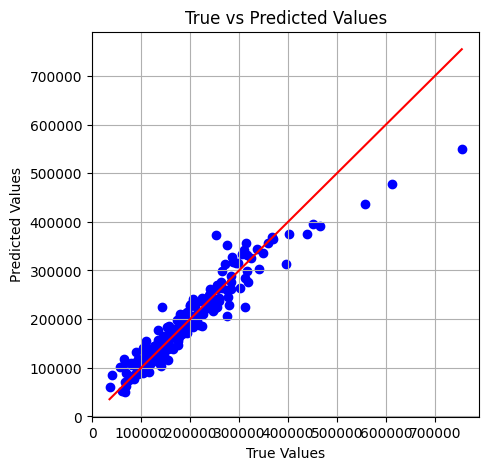

In [22]:
# Pipeline creation
verbose = False

# Dynamically select the model based on Config_params
printt(Config_params['model'],'Model')
if Config_params['model'] == 'DecisionTree':
    model = DecisionTreeRegressor(random_state=42)
elif Config_params['model'] == 'CatBoost':
    model = CatBoostRegressor(random_state=42, verbose=0)  # Set verbose=0 for CatBoost to match the verbosity setting
    #categorical_columns = X.select_dtypes(include=['O']).columns.tolist()
    #catboost_regressor = CatBoostRegressor(random_seed=42, silent=True, cat_features = categorical_columns)
    #print(f"categorical_columns : Length={len(categorical_columns)} {categorical_columns}")


pipeline = Pipeline([
    ('drop_ID', drop_ID(verbose=verbose)),
    ('remove_nas_col', remove_NAs_col(threshold=Config_params['nan_counts_threshold'], verbose=verbose)),
    ('imput_nas_row', imput_NAs_row(verbose=verbose)),
    ('handle_categoric', handle_categoric(drop_categoric=Config_params['drop_categoric'], verbose=verbose)),
    ('reg', model)  # Use the dynamically selected model
])

pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_validation)
log_rmse = np.log(np.sqrt(mean_squared_error(y_validation, y_pred)))
printt(np.sqrt(mean_squared_error(y_validation, y_pred)),'rmse')
printt(log_rmse,'log_rmse')
plot_perd(y_validation, y_pred,True)


# Submission
Finally predict on the competition test data using the model.

In [24]:
pipeline.fit(X,y)
y_pred = pipeline.predict(testset_df)
output = pd.DataFrame({'Id': id_file,
                       'SalePrice': y_pred.squeeze()})
output.to_csv('./project/submission.csv', index=False)
output.head()

,Id,SalePrice
0,1461,127060.104369
1,1462,159518.746321
2,1463,189058.061091
3,1464,193777.322683
4,1465,183181.596391
